# Compliance optimization
Minimal example for a 2D compliance topology optimization using semi-automatic gradients and OC as optimizer.

Start by importing relevant Python libraries:
- `numpy` for linear algebra tools (*i.e.* matrix and vector operations) to set up a force vector etc.
- `pymoto` for modular topology optimization framework

In [1]:
%matplotlib widget
import numpy as np
import pymoto as pym
import matplotlib 
matplotlib.use("widget")  # Use `pip install jupyter ipympl` to run

Next, some settings are entered, such as the size of the domain, the minimum density, and filter radius

In [2]:
 
nx, ny = 120, 40  # Number of elements in x- and y-direction
xmin = 1e-9  # Minimum density
filter_radius = 2.0  # Filter radius
volfrac = 0.5  # Target volume fraction

A finite-element grid needs to be setup

In [3]:
domain = pym.DomainDefinition(nx, ny)
ndof = 2
# Calculate boundary dof indices
boundary_nodes = domain.get_nodenumber(0, np.arange(ny + 1))
boundary_dofs = np.repeat(boundary_nodes * ndof, ndof, axis=-1) + np.tile(np.arange(ndof), len(boundary_nodes))

# Which dofs to put a force on? The 1 is added for a force in y-direction (x-direction would be zero)
force_dofs = ndof * domain.get_nodenumber(nx, ny // 2) + 1

# Generate a force vector
f = np.zeros(domain.nnodes * ndof)
f[force_dofs] = 1.0  # Uniform force of 1.0 at all selected dofs

Make signal for design vector, and fill with initial values

In [4]:
sx = pym.Signal('x', state=np.ones(domain.nel) * volfrac)

Now everything is ready to start setting up the steps for the optimization problem. Modules are linked together using signals to get the desired output.

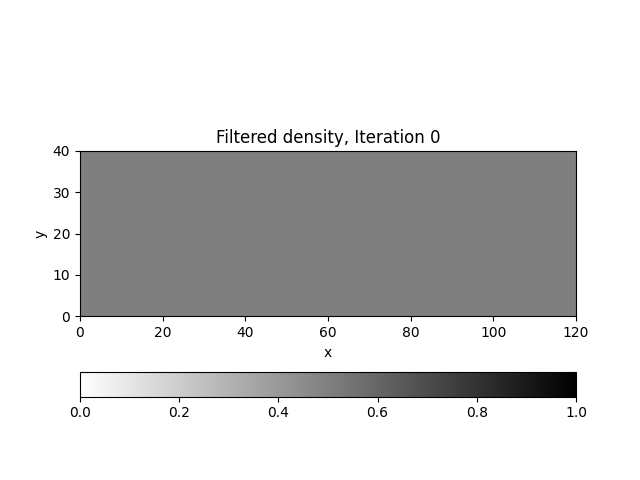

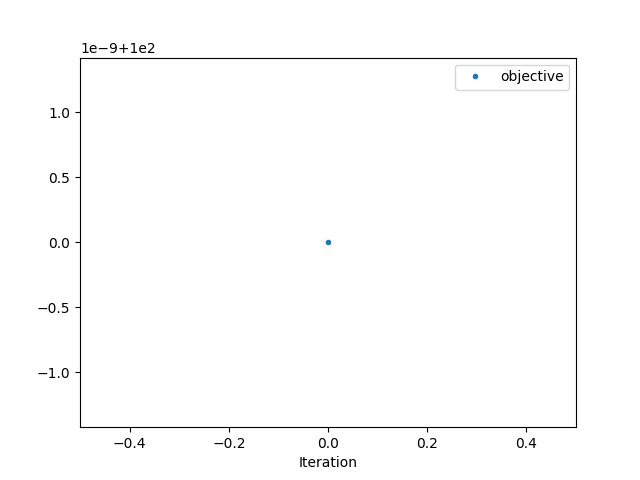

In [5]:
# Density filter
sxfilt = pym.DensityFilter(domain, radius=filter_radius)(sx)
sxfilt.tag = 'Filtered density'

# Show the design on the screen as it optimizes
pym.PlotDomain(domain, saveto="out/design", clim=[0, 1])(sxfilt)

# SIMP material interpolation
sSIMP = pym.MathGeneral(f"{xmin} + {1.0 - xmin}*inp0^3")(sxfilt)

# Stiffness matrix assembly module
sK = pym.AssembleStiffness(domain, bc=boundary_dofs)(sSIMP)

# Linear system solver. The linear solver can be chosen by uncommenting any of the following lines.
su = pym.LinSolve()(sK, f)

# Compliance calculation c = f^T u
scompl = pym.EinSum('i, i->')(su, f)
scompl.tag = 'compliance'

# MMA needs correct scaling of the objective
sg0 = pym.Scaling(scaling=100.0)(scompl)
sg0.tag = "objective"

pym.PlotIter()(sg0)  # Plot iteration history

Everything is run once, 

It.    0, f0 =  1.00e+02, Δf =  1.00e+02
It.    1, f0 =  5.86e+01, Δf = -4.14e+01
It.    2, f0 =  4.10e+01, Δf = -1.76e+01
It.    3, f0 =  3.38e+01, Δf = -7.26e+00
It.    4, f0 =  3.14e+01, Δf = -2.35e+00
It.    5, f0 =  2.99e+01, Δf = -1.49e+00
It.    6, f0 =  2.88e+01, Δf = -1.15e+00
It.    7, f0 =  2.79e+01, Δf = -9.31e-01
It.    8, f0 =  2.72e+01, Δf = -6.69e-01
It.    9, f0 =  2.66e+01, Δf = -5.89e-01


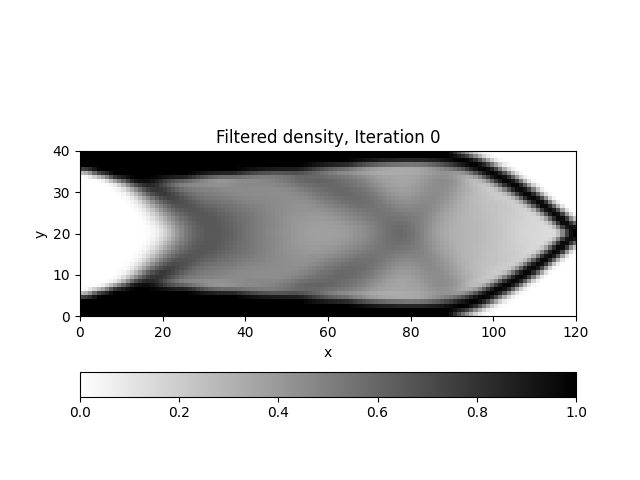

In [6]:
pym.minimize_oc(sx, sg0, maxit=10)
# The final design (plot again)
pym.PlotDomain(domain, clim=[0, 1])(sxfilt)